In [ ]:
!pip install tensorflow shap lime scikit-learn pandas numpy matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f0609b7d9cda2af4174f873d1fb2a13be888a0969911270951b45274cb6d9ae8
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, roc_curve
)

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Explainability
import shap
from lime.lime_tabular import LimeTabularExplainer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

input_path = "/content/drive/My Drive/Colab Notebooks/NFRF ML/Final_ITD.csv"

df = pd.read_csv(input_path)
print(df.shape)
df.head()

Mounted at /content/drive
(29880, 38)


,employee_seniority_years,is_contractor,employee_classification,has_foreign_citizenship,has_criminal_record,has_medical_history,risk_travel_indicator,num_print_commands,total_printed_pages,num_print_commands_off_hours,...,num_entries,num_exits,total_presence_minutes,entered_during_night_hours,num_unique_campus,early_entry_flag,entry_during_weekend,first_entry_minutes,last_exit_minutes,is_emp_malicious
0,0.547490,-0.375706,-0.048271,-0.477401,-0.198891,-0.436447,-0.008182,-0.592447,-0.347391,-0.172272,...,-0.999648,-0.999648,-1.187573,-0.039692,-1.069308,-0.069831,-0.29653,-0.114514,-0.181596,1
1,-0.653307,2.661657,-1.388731,-0.477401,5.027891,-0.436447,-0.008182,-0.592447,-0.347391,-0.172272,...,1.392878,1.392878,0.426682,-0.039692,0.481181,-0.069831,-0.29653,-0.159694,-0.993543,0
2,-1.320417,-0.375706,-0.048271,2.094676,-0.198891,-0.436447,-0.008182,1.381759,2.387795,-0.172272,...,1.392878,1.392878,0.564441,-0.039692,0.481181,-0.069831,-0.29653,-0.498547,-0.741181,1
3,0.013802,-0.375706,1.292189,-0.477401,-0.198891,-0.436447,-0.008182,0.197236,-0.098737,-0.172272,...,-0.999648,-0.999648,-1.187573,-0.039692,-1.069308,-0.069831,-0.29653,-0.114514,-0.181596,0
4,0.013802,-0.375706,-1.388731,-0.477401,-0.198891,2.291231,-0.008182,1.381759,0.100185,-0.172272,...,0.196615,0.196615,0.726926,-0.039692,0.481181,-0.069831,-0.29653,-0.769629,-0.357152,0


In [ ]:
X = df.drop(columns=["is_emp_malicious"])   # Change if target name differs
y = df["is_emp_malicious"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 16   # latent feature size (can be tuned)

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation="relu")(input_layer)
encoded = Dense(encoding_dim, activation="relu")(encoded)

decoded = Dense(32, activation="relu")(encoded)
decoded = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

autoencoder.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7095 - val_loss: 0.3333
Epoch 2/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2815 - val_loss: 0.1878
Epoch 3/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2093 - val_loss: 0.1456
Epoch 4/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1717 - val_loss: 0.1213
Epoch 5/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1265 - val_loss: 0.1059
Epoch 6/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1118 - val_loss: 0.0943
Epoch 7/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0984 - val_loss: 0.0843
Epoch 8/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0764 - val_loss: 0.0998
Epoch 9/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0823 - val_loss: 0.0731
Epoch 10/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0714 - val_loss: 0.0733
Epoch 11/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0628 - val_loss: 0.0686
Epoch 12/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

In [ ]:
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded  = encoder.predict(X_test_scaled)

747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
mlp = Sequential([
    Dense(32, activation="relu", input_shape=(encoding_dim,)),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])

mlp.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

mlp.fit(
    X_train_encoded,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


673/673 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6267 - loss: 0.6263 - val_accuracy: 0.7290 - val_loss: 0.5063
Epoch 2/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7252 - loss: 0.5209 - val_accuracy: 0.7449 - val_loss: 0.4917
Epoch 3/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7431 - loss: 0.5003 - val_accuracy: 0.7537 - val_loss: 0.4893
Epoch 4/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7537 - loss: 0.4929 - val_accuracy: 0.7566 - val_loss: 0.4743
Epoch 5/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7523 - loss: 0.4845 - val_accuracy: 0.7654 - val_loss: 0.4653
Epoch 6/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7535 - loss: 0.4827 - val_accuracy: 0.7604 - val_loss: 0.4655
Epoch 7/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7562 - loss: 0.4760 - val_accuracy: 0.7662 - val_loss: 0.4593
Epoch 8/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7624 - loss: 0.4668 - val_accuracy: 0.7725 - val_

In [ ]:
y_prob = mlp.predict(X_test_encoded).ravel()
y_pred = (y_prob >= 0.5).astype(int)

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_prob)

print("AE-MLP Performance Metrics")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")

print("\nClassification Report")
print(classification_report(y_test, y_pred))

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AE-MLP Performance Metrics
Accuracy  : 0.7877
Precision : 0.8681
Recall    : 0.6784
F1-score  : 0.7616
ROC-AUC   : 0.8704

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      2988
           1       0.87      0.68      0.76      2988

    accuracy                           0.79      5976
   macro avg       0.80      0.79      0.79      5976
weighted avg       0.80      0.79      0.79      5976



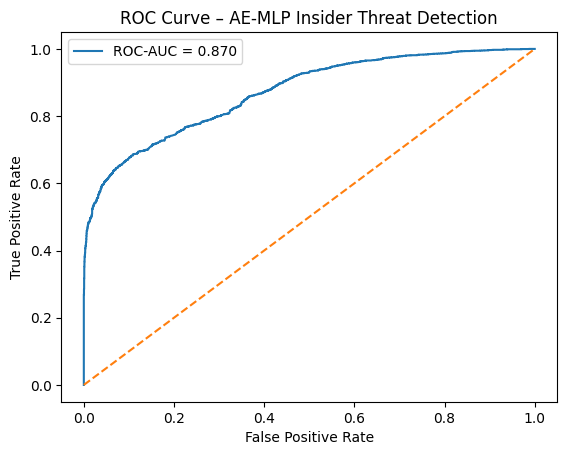

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – AE-MLP Insider Threat Detection")
plt.legend()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

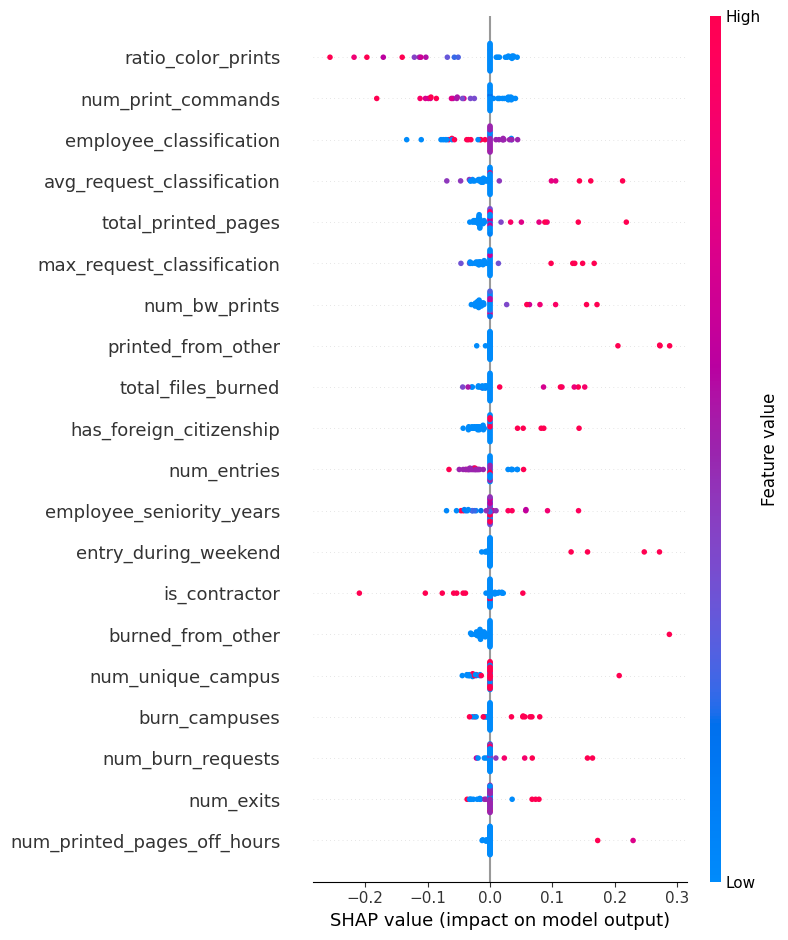

In [ ]:
import shap

background = shap.sample(X_train_scaled, 100)

def ae_mlp_predict_original(X):
    # First, encode the input using the autoencoder's encoder part
    X_encoded = encoder.predict(X, verbose=0)
    # Then, predict with the MLP
    return mlp.predict(X_encoded, verbose=0).ravel()

explainer = shap.KernelExplainer(ae_mlp_predict_original, background)

# Calculate SHAP values for the original scaled test set
shap_values = explainer.shap_values(X_test_scaled[:50])

# Use the original feature names for the plot
shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=X.columns)

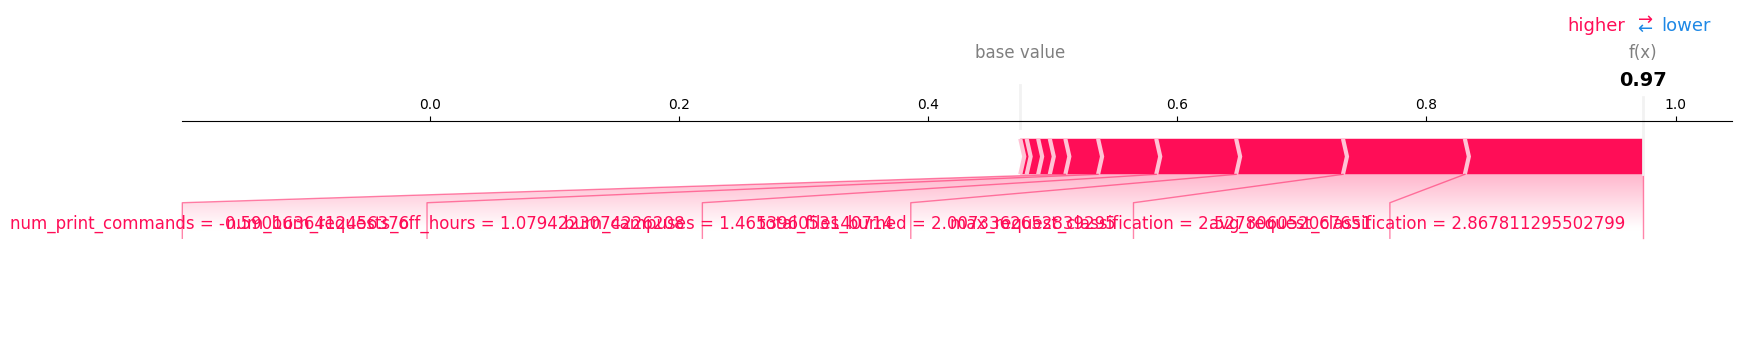

In [ ]:
import shap

idx = 3

shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test_scaled[idx],
    feature_names=X.columns, # Pass original feature names here
    matplotlib=True
)

In [ ]:
!pip install lime --upgrade --force-reinstall
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(
    training_data=X_train_scaled, # Use original scaled training data
    feature_names=X.columns.tolist(), # Use original feature names
    class_names=["Normal", "Insider Threat"],
    mode="classification"
)

i = 3
# The prediction function for LIME also needs to encode first
lime_exp = lime_explainer.explain_instance(
    X_test_scaled[i], # Use original scaled test instance
    lambda x: np.column_stack([1 - ae_mlp_predict_original(x), ae_mlp_predict_original(x)]),
    num_features=10
)

lime_exp.show_in_notebook(show_table=True)

  Using cached lime-0.2.0.1-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 92.3 MB/s eta 0:00:00
   ━━━━